# Tap dependent impedance of transformers

With an adjustment of a tap position of a transformer, the number of windings is adjusted, which influences the impedence. The user can provide characteristics of the dependance of the variables vk_percent and vkr_percent on the tap position. A helper function in pandapower control module converts the provided points in a characteristic object with quadratic spline interpolation (or a user-defined characteristic object with a custom interpolation approach) and writes it in the trafo table. Finally, a diagnostic function checks for inconsistensies and provides information to the user.

In [1]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.control
import json

In [2]:
def add_trafo_connection(net, hv_bus, element_type="trafo"):
    cb = pp.create_bus(net, vn_kv=0.4)
    pp.create_load(net, cb, 0.2, 0.05)
    
    if element_type=="trafo3w":
        cbm = pp.create_bus(net, vn_kv=0.9)
        pp.create_load(net, cbm, 0.1, 0.03)
        pp.create_transformer3w_from_parameters(net, hv_bus=hv_bus, mv_bus=cbm, lv_bus=cb, 
                                                vn_hv_kv=20., vn_mv_kv=0.9, vn_lv_kv=0.45, sn_hv_mva=0.6, 
                                                sn_mv_mva=0.5, sn_lv_mva=0.4, vk_hv_percent=1., 
                                                vk_mv_percent=1., vk_lv_percent=1., vkr_hv_percent=0.3, 
                                                vkr_mv_percent=0.3, vkr_lv_percent=0.3, pfe_kw=0.2, 
                                                i0_percent=0.3, tap_neutral=0., tap_pos=2, 
                                                tap_step_percent=1., tap_min=-2, tap_max=2)
    else:
        pp.create_transformer(net, hv_bus=hv_bus, lv_bus=cb, std_type="0.25 MVA 20/0.4 kV", tap_pos=2)
                

def create_net():
    net = pp.create_empty_network()
    vn_kv = 20
    b1 = pp.create_bus(net, vn_kv=vn_kv)
    pp.create_ext_grid(net, b1, vm_pu=1.01)
    b2 = pp.create_bus(net, vn_kv=vn_kv)
    l1 = pp.create_line_from_parameters(net, b1, b2, 12.2, r_ohm_per_km=0.08, x_ohm_per_km=0.12,
                                        c_nf_per_km=300, max_i_ka=.2, df=.8)
    for i in range(2):
        add_trafo_connection(net, b2)
        
    return net

In [3]:
net = create_net()

We can either create the characteristics by creating the objects for characteristics and setting their index to the respective columns. Alternatively, we can use a convenience function to create set up the characteristics for vk_percent and vkr_percent. The function can be applied to a single index or for multiple transformers at a time. The imput parameters must have a correct shape:

In [4]:
pp.control.create_trafo_characteristics(net, 'trafo', 0, 'vk_percent', 
                                        [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])  # single mode
pp.control.create_trafo_characteristics(net, 'trafo', [0], 'vkr_percent', 
                                        [[-2, -1, 0, 1, 2]], [[1.3, 1.4, 1.44, 1.5, 1.6]])  # multiple indices

The characteristic set in the convenience function is the SplineCharacteristic object that relies on quadratic spline interpolation with interp1d from SciPy. Let us check the characteristic:

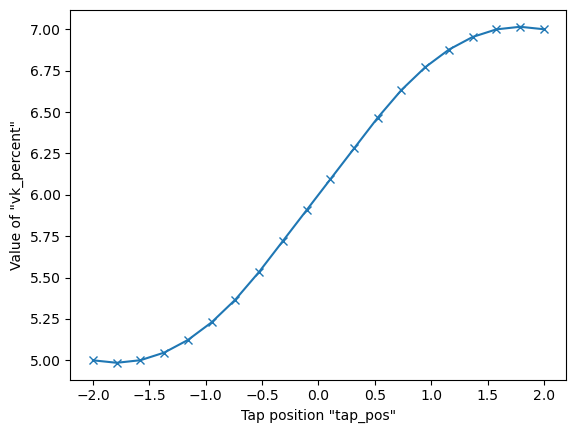

In [5]:
pp.control.plot_characteristic(net.characteristic.object.at[0], -2, 2, 
                               xlabel='Tap position "tap_pos"', ylabel='Value of "vk_percent"')

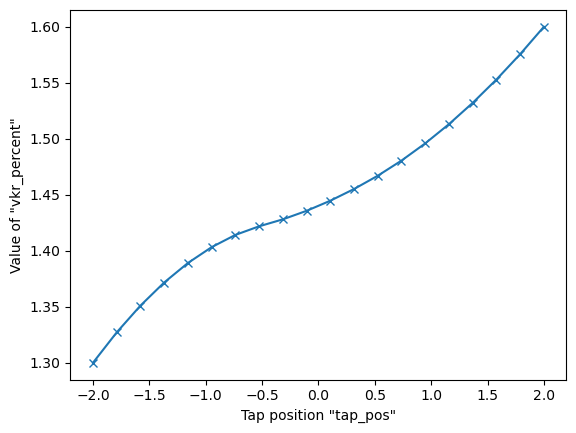

In [6]:
pp.control.plot_characteristic(net.characteristic.object.at[1], -2, 2,
                               xlabel='Tap position "tap_pos"', ylabel='Value of "vkr_percent"')

In [7]:
pp.runpp(net)

Let us verify that the adjusted values were considered in the calculation:

In [8]:
net.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-153.390736,0.2,0.05
3,0.935414,-152.890645,0.2,0.05


We can see that the voltage values are different, even though the connections are identical. Now let us compare the computation time:

In [9]:
net2 = create_net()

In [10]:
%timeit pp.runpp(net2)

9.54 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit pp.runpp(net)

10.5 ms ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The calculation with tap dependent impedance is somewhat slower.

Now, let us compare the performance of the controller for reference

In [12]:
net3 = create_net()
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [1.3, 1.4, 1.44, 1.5, 1.6])
pp.control.TapDependentImpedance(net3, [0], 0, output_variable="vk_percent")
pp.control.TapDependentImpedance(net3, [0], 1, output_variable="vkr_percent")

This TapDependentImpedance has the following parameters: 

index:             1
json_excludes:     ['self', '__class__']

In [13]:
%timeit pp.runpp(net3, run_control=True)

28.4 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The computational time is substantially higher!

The results from using the characteristics in pandapower directly and via controllers are identical:

In [14]:
net3.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-153.390736,0.2,0.05
3,0.935414,-152.890645,0.2,0.05


In [15]:
assert np.allclose(net.res_bus.vm_pu, net3.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net.res_bus.va_degree, net3.res_bus.va_degree, atol=1e-6, rtol=0)

# 3-Winding Transformers

In [16]:
net4 = create_net()
net5 = create_net()
for i in range(2):
    add_trafo_connection(net4, net4.trafo.at[0, 'hv_bus'], "trafo3w")
    add_trafo_connection(net5, net5.trafo.at[0, 'hv_bus'], "trafo3w")

In [17]:
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_hv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])

pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_hv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])

pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_mv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])

pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_mv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])

pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_lv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])

pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_lv_percent', 
                                        [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])

net4.characteristic

,object
0,SplineCharacteristic
1,SplineCharacteristic
2,SplineCharacteristic
3,SplineCharacteristic
4,SplineCharacteristic
5,SplineCharacteristic


In [18]:
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.85, 0.9, 1, 1.1, 1.15])
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.27, 0.28, 0.3, 0.32, 0.33])

SplineCharacteristic

In [19]:
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_hv_percent",  element="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_hv_percent", element="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_mv_percent",  element="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_mv_percent", element="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_lv_percent",  element="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_lv_percent", element="trafo3w")

This TapDependentImpedance has the following parameters: 

index:             5
json_excludes:     ['self', '__class__']

In [20]:
%timeit pp.runpp(net4)

14.2 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit pp.runpp(net5, run_control=True)

46.2 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
assert np.allclose(net4.res_bus.vm_pu, net5.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net4.res_bus.va_degree, net5.res_bus.va_degree, atol=1e-6, rtol=0)
pd.merge(net4.res_bus[["vm_pu", "va_degree"]], net5.res_bus[["vm_pu", "va_degree"]], 
         left_index=True, right_index=True)

,vm_pu_x,va_degree_x,vm_pu_y,va_degree_y
0,1.010000,0.000000,1.010000,0.000000
1,1.007345,-0.200101,1.007345,-0.200101
2,0.933386,-153.003717,0.933386,-153.003717
3,0.933386,-153.003717,0.933386,-153.003717
4,1.129101,-0.545611,1.129101,-0.545611
5,1.004802,-0.428880,1.004802,-0.428880
6,1.129567,-0.497905,1.129567,-0.497905
7,1.005088,-0.397258,1.005088,-0.397258


Also in the case of the 3-winding transformers, the results for direct calculation in pandapower and in controllers match.

# Undefined characteristics

If some transformers have characteristics that do not define all of the columns, the behavior is to ignore the missing characteristic. If tap_dependent_impedance is set to True, but all the characteristics are missing, an error is raised.

In [23]:
net6 = create_net()
pp.control.create_trafo_characteristics(net6, 'trafo', [0], 'vk_percent', 
                                        [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]])
pp.control.create_trafo_characteristics(net6, 'trafo', [0], 'vkr_percent', 
                                        [[-2, -1, 0, 1, 2]], [[1.3, 1.4, 1.44, 1.5, 1.6]])
pp.control.create_trafo_characteristics(net6, 'trafo', [1], 'vk_percent', 
                                        [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]])

In [24]:
net6.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic,vkr_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,0,1
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,2,<NA>


In [25]:
# does not raise an error
pp.runpp(net6)

In [26]:
# this would raise an error:

# net6.trafo.at[1, "vk_percent_characteristic"] = None
# pp.runpp(net6)

# Creating transformers with characteristics

The functions to create transformers were updated to include the parameter tap_dependent_impedance and add the references to the characteristics.

In [27]:
net_create = create_net()
add_trafo_connection(net_create, net_create.trafo.at[0, 'hv_bus'], "trafo3w")

In [28]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True


In [29]:
c = pp.control.SplineCharacteristic(net_create, [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])
pp.create_transformer(net_create, hv_bus=net_create.trafo.at[0, 'hv_bus'], 
                      lv_bus=net_create.trafo.at[0, 'lv_bus'], std_type="0.25 MVA 20/0.4 kV", tap_pos=2, 
                      tap_dependent_impedance=True, vk_percent_characteristic=0)

2

In [30]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,False,<NA>
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,False,<NA>
2,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,0


In [31]:
pp.runpp(net_create)

# File I/O

The file I/O for characteristics is now implemented via adding the characteristic table:

In [32]:
net2 = pp.from_json_string(pp.to_json(net))
net2.characteristic

,object
0,SplineCharacteristic
1,SplineCharacteristic


De-serialization is working:

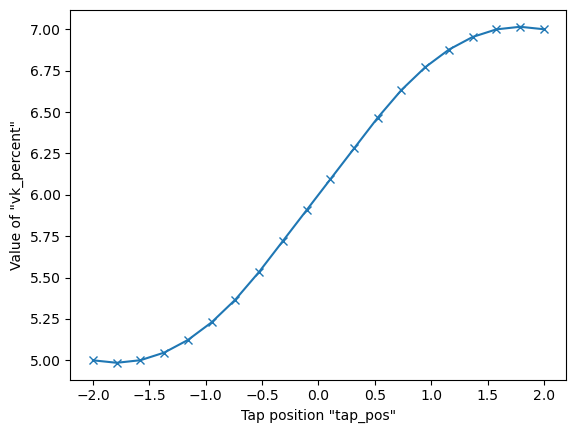

In [33]:
pp.control.plot_characteristic(net2.characteristic.object.at[0], -2, 2,
                               xlabel='Tap position "tap_pos"', ylabel='Value of "vk_percent"')

# Diagnostic

The diagnostic function for transformer tap characteristics checks the following:
 
* Are there characteristics for tap dependent impedance?
* Are any columns missing?
* Are there characteristics that are referenced in the trafo or trafo3w table, but are missing in net.characteristic?
* Do the characteristic values for the neutral tap position deviate from the element table parameter?

The results are displayed to the user with the help of logging statements.

In [34]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic,vkr_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,0,1
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,False,<NA>,<NA>


In [35]:
pp.control.trafo_characteristics_diagnostic(net)

hp.pandapower.control.util.diagnostic - INFO: Checking transformer characteristics
hp.pandapower.control.util.diagnostic - INFO: trafo: found 1 transformer(s) with tap-dependent impedance
hp.pandapower.control.util.diagnostic - INFO: No trafo3w with tap-dependent impedance found.


In [36]:
pp.control.trafo_characteristics_diagnostic(net6)

hp.pandapower.control.util.diagnostic - INFO: Checking transformer characteristics
hp.pandapower.control.util.diagnostic - INFO: trafo: found 2 transformer(s) with tap-dependent impedance
hp.pandapower.control.util.diagnostic - INFO: trafo: vkr_percent_characteristic is missing for some transformers
hp.pandapower.control.util.diagnostic - INFO: No trafo3w with tap-dependent impedance found.


In [37]:
# let's make some invalid configurations
# missing any characteristic
pp.create_transformer(net, hv_bus=net.trafo.at[0, 'hv_bus'], 
                      lv_bus=net.trafo.at[0, 'lv_bus'], std_type="0.25 MVA 20/0.4 kV", tap_pos=2, 
                      tap_dependent_impedance=True)
net.trafo.at[0, "vk_percent"] += 1e-6
add_trafo_connection(net, net.trafo.at[0, 'hv_bus'], "trafo3w")
# missing columns for characteristics
net.trafo3w['tap_dependent_impedance'] = True

display(net.trafo)
display(net.trafo3w)

# diagnostic
pp.control.trafo_characteristics_diagnostic(net)

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic,vkr_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.000001,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,0,1
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.000000,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,False,<NA>,<NA>
2,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.000000,1.44,0.8,0.32,150.0,hv,0,-2,2,2.5,0.0,2,False,1,1.0,True,True,<NA>,<NA>


,name,std_type,hv_bus,mv_bus,lv_bus,sn_hv_mva,sn_mv_mva,sn_lv_mva,vn_hv_kv,vn_mv_kv,vn_lv_kv,vk_hv_percent,vk_mv_percent,vk_lv_percent,vkr_hv_percent,vkr_mv_percent,vkr_lv_percent,pfe_kw,i0_percent,shift_mv_degree,shift_lv_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_at_star_point,in_service,vk0_hv_percent,vk0_mv_percent,vk0_lv_percent,vkr0_hv_percent,vkr0_mv_percent,vkr0_lv_percent,vector_group,tap_dependent_impedance
0,None,None,1,5,4,0.6,0.5,0.4,20.0,0.9,0.45,1.0,1.0,1.0,0.3,0.3,0.3,0.2,0.3,0.0,0.0,None,0,-2,2,1.0,NaN,2,False,True,NaN,NaN,NaN,NaN,NaN,NaN,None,True


hp.pandapower.control.util.diagnostic - INFO: Checking transformer characteristics
hp.pandapower.control.util.diagnostic - INFO: trafo: found 2 transformer(s) with tap-dependent impedance
hp.pandapower.control.util.diagnostic - WARNING: Some transformers in trafo table have tap_dependent_impedance set to True, but no defined characteristics. Power flow calculation will raise an error.
hp.pandapower.control.util.diagnostic - INFO: trafo: vk_percent_characteristic is missing for some transformers
hp.pandapower.control.util.diagnostic - WARNING: The characteristic value of 6.0 at the neutral tap position 0 does not match the value 6.000001 of vk_percent for the trafo with index 0 (deviation of -1.000000000139778e-06)
hp.pandapower.control.util.diagnostic - INFO: trafo: vkr_percent_characteristic is missing for some transformers
hp.pandapower.control.util.diagnostic - INFO: trafo3w: found 1 transformer(s) with tap-dependent impedance
hp.pandapower.control.util.diagnostic - WARNING: No colu